In [195]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import os
from pathlib import Path
import warnings

In [196]:
warnings.filterwarnings("ignore")

In [197]:
root = Path().resolve().parent  # get project root.

In [198]:
stock_data = pd.read_csv(f"{root}/data/clean_data/stock_data.csv", index_col= 'Date')
ETF_data = pd.read_csv(f"{root}/data/clean_data/ETF_data.csv", index_col= 'Date')
econ = pd.read_csv(f"{root}/data/clean_data/econ.csv", index_col= 'Date')

In [199]:
# map all stock to corresponding ETF
stock_to_etf = {
    'AAPL': 'XLK',  # Technology ETF
    'GOOGL': 'XLK',
    'MSFT': 'XLK',
    'AMZN': 'XLK',
    'JNJ': 'XLV',  # Healthcare ETF
    'PFE': 'XLV',
    'JPM': 'XLF',  # Financials ETF
    'GS': 'XLF',
    'XOM': 'XLE',  # Energy ETF
    'CVX': 'XLE'
} 

In [200]:
stock_price = stock_data[[col for col in stock_data.columns if col.startswith('Adj')]]
stock_price.columns

Index(['Adj Close_AAPL', 'Adj Close_AMZN', 'Adj Close_CVX', 'Adj Close_GOOGL',
       'Adj Close_GS', 'Adj Close_JNJ', 'Adj Close_JPM', 'Adj Close_MSFT',
       'Adj Close_PFE', 'Adj Close_XOM'],
      dtype='object')

In [201]:
ETF_price = ETF_data[[col for col in ETF_data.columns if col.startswith('Adj')]]
ETF_price.columns

Index(['Adj Close_XLE', 'Adj Close_XLF', 'Adj Close_XLK', 'Adj Close_XLV'], dtype='object')

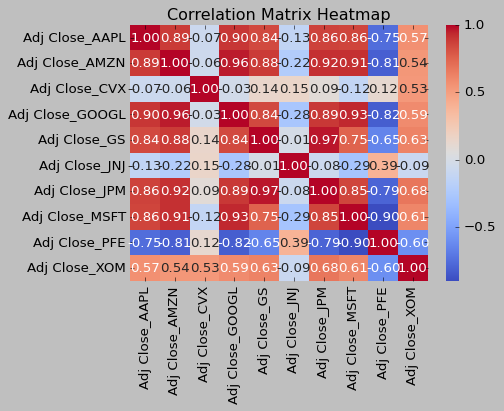

In [202]:
corr_matrix = stock_price.corr(method='pearson')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


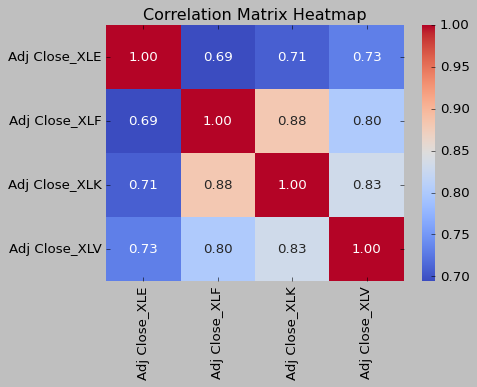

In [203]:
corr_matrix = ETF_price.corr(method='pearson')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [204]:
def compute_volatility(df, period):
  new_col = ["volatility_" + col[10:]  for col in df]
  log_returns = np.log(df/df.shift(1)).fillna(0)
  volatility = log_returns.rolling(window=period).std() * np.sqrt(period)
  volatility = volatility.fillna(0)
  volatility.columns = new_col
  return volatility

In [205]:
df = stock_price.copy()
stock_vol = compute_volatility(df, 5) # one week
stock_vol.columns

Index(['volatility_AAPL', 'volatility_AMZN', 'volatility_CVX',
       'volatility_GOOGL', 'volatility_GS', 'volatility_JNJ', 'volatility_JPM',
       'volatility_MSFT', 'volatility_PFE', 'volatility_XOM'],
      dtype='object')

In [206]:
df = ETF_price.copy()
ETF_vol = compute_volatility(df, 5) # one week
ETF_vol.columns

Index(['volatility_XLE', 'volatility_XLF', 'volatility_XLK', 'volatility_XLV'], dtype='object')

In [207]:
vol = pd.concat([stock_vol, ETF_vol], axis= 1)
vol.shape

(1065, 14)

In [208]:
vol.shape

(1065, 14)

In [209]:
%matplotlib inline
plt.style.use('classic')  

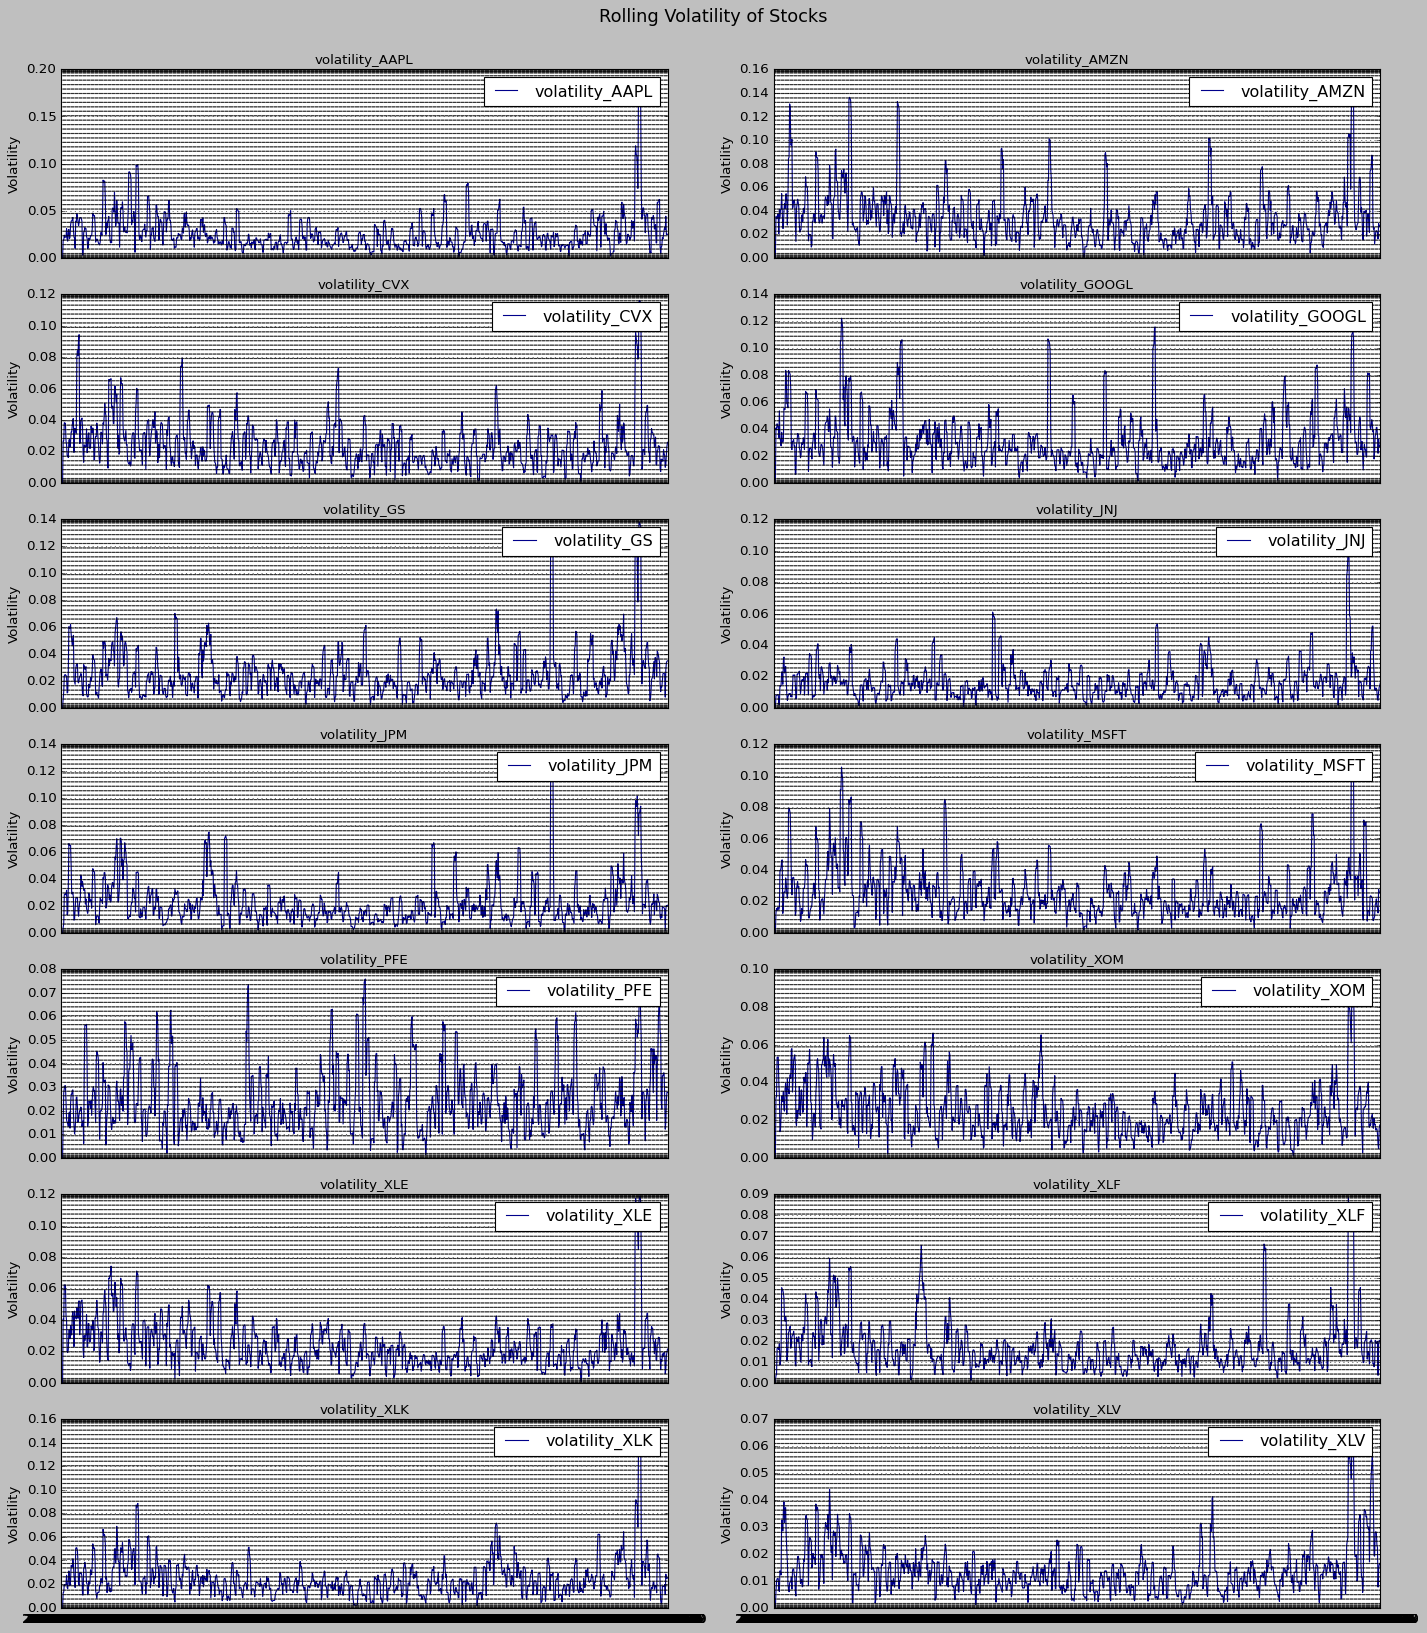

In [210]:
ncols = 2
no_of_assets= vol.shape[1] 
nrows=(no_of_assets + 1)//ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 20), sharex=True)
axes = axes.flatten()

# Plot each column of the volatility DataFrame
for i, column in enumerate(vol.columns):
    ax = axes[i]
    ax.plot(vol[column], label=column, color='darkblue')
    ax.set_title(f'{column}', fontsize=12)
    ax.set_ylabel('Volatility')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.suptitle("Rolling Volatility of Stocks", fontsize=16, y=1.02)
plt.show()


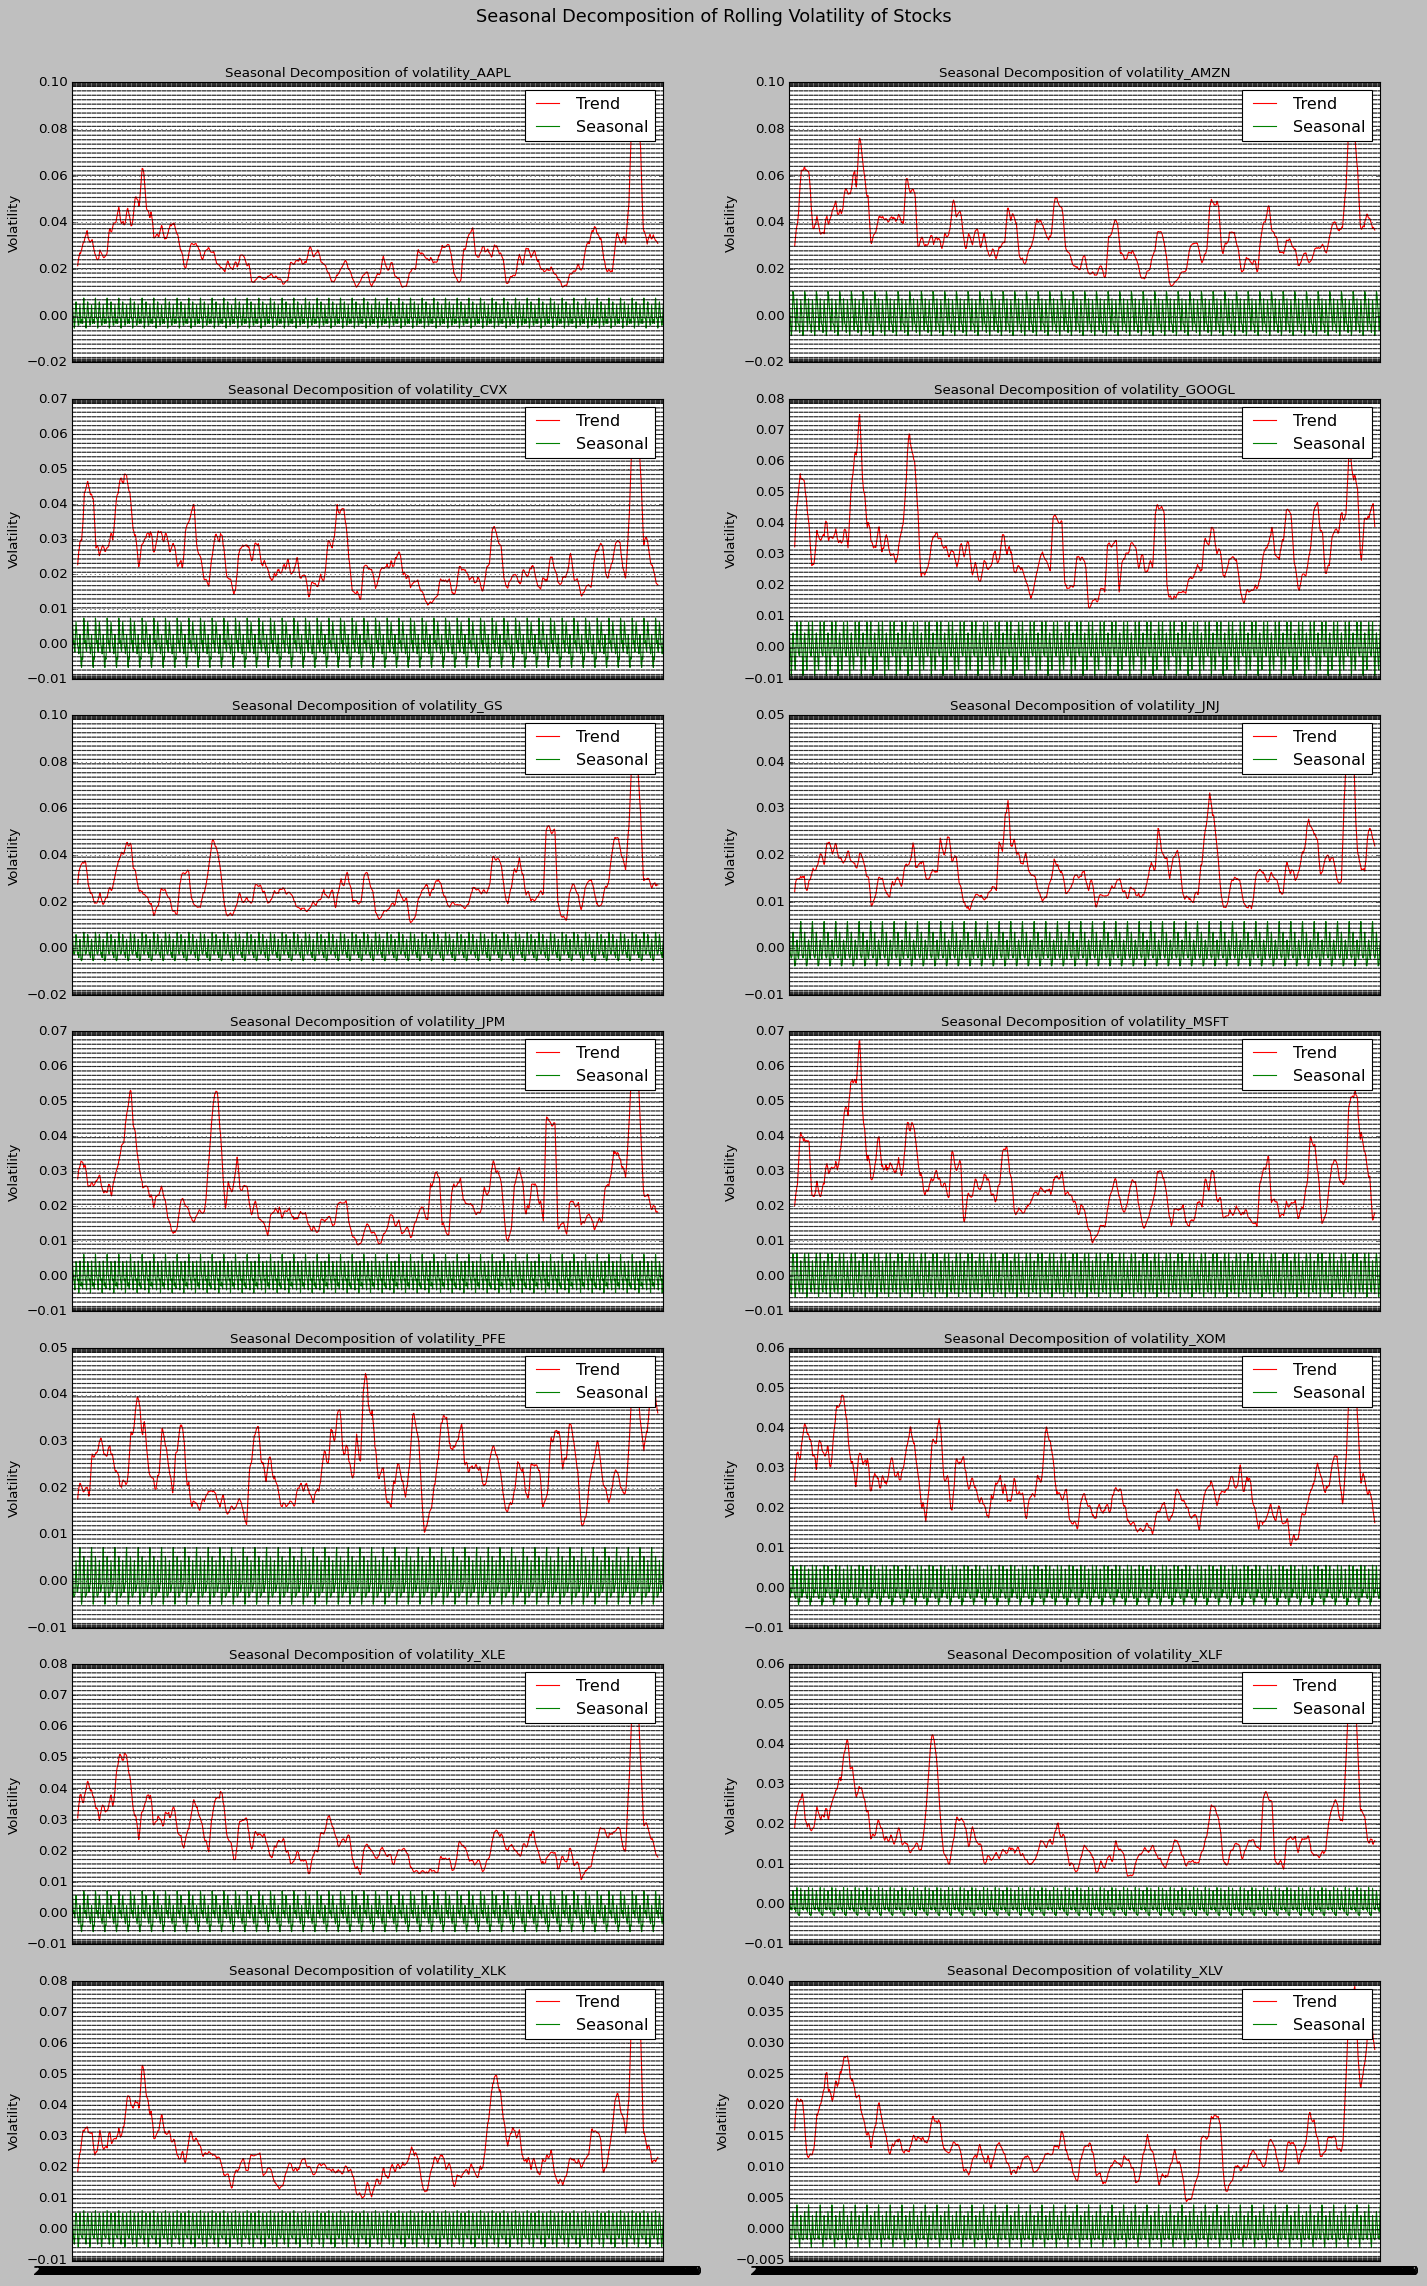

In [211]:
decomposition_results = {}

for column in vol.columns:
    decomposition = seasonal_decompose(vol[column], model='additive', period=21)
    decomposition_results[column] = decomposition
    
no_of_assets = vol.shape[1]
n_cols = 2
n_rows = (no_of_assets + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = axes.flatten()

i = 0
for k, v in decomposition_results.items():
    ax = axes[i]
    ax.plot(vol.index, v.trend, label='Trend', color='red', linewidth=1)
    ax.plot(vol.index, v.seasonal, label='Seasonal', color='green', linewidth=1)
    ax.set_title(f"Seasonal Decomposition of {k}", fontsize=12)
    ax.set_ylabel('Volatility')
    ax.grid(True)
    ax.legend()
    i += 1

plt.tight_layout()
plt.suptitle("Seasonal Decomposition of Rolling Volatility of Stocks", fontsize=16, y=1.02)
plt.show()



In [212]:
def Hypothesis_test(val):
  res = {}
  for col in val.columns:
    result_adf= adfuller(val[col], regression= 'ct')
    result_kpss = kpss(val[col], regression='ct')  # 'c' for level, 'ct' for trend
    res[col] = {
            'ADF Statistic': result_adf[0],
            'ADF p-value': result_adf[1],
            'ADF Critical Value 1%': result_adf[4]['1%'],
            'ADF Critical Value 5%': result_adf[4]['5%'],
            'ADF Critical Value 10%': result_adf[4]['10%'],
            "KPSS Statistic": result_kpss[0],
            "KPS p-value": result_kpss[1],
            "KPSS Critical Value 1%": result_kpss[3]['1%'],
            "KPSS Critical Value 5%": result_kpss[3]['5%'],
            "KPSS Critical Value 10%": result_kpss[3]['10%']
        }

    res_df = pd.DataFrame(res).T
    res_df.index.name = 'Returns from:'
  return res_df

def compute_return(df):
  new_col = ["returns_" + col[10:] for col in df]
  log_returns = np.log(df/df.shift(1)).fillna(0)
  log_returns.columns = new_col
  return log_returns

def compute_momentun(df):
  new_col = ["momentum_" + col[10:] for col in df]
  log_momentum = np.log(df/df.shift(5)).fillna(0)
  log_momentum.columns = new_col
  return log_momentum

In [ ]:
df = stock_price.copy()
stock_returns = compute_return(df) # returns
stock_momentum = compute_momentun(df) # momentum

print(stock_returns.shape, stock_momentum.shape)

In [214]:
res = Hypothesis_test(stock_returns)

res

,ADF Statistic,ADF p-value,ADF Critical Value 1%,ADF Critical Value 5%,ADF Critical Value 10%,KPSS Statistic,KPS p-value,KPSS Critical Value 1%,KPSS Critical Value 5%,KPSS Critical Value 10%
Returns from:,,,,,,,,,,
returns_AAPL,-9.051527,2.776435e-13,-3.967401,-3.414672,-3.129511,0.043520,0.1,0.216,0.146,0.119
returns_AMZN,-33.501876,0.000000e+00,-3.967304,-3.414624,-3.129484,0.064078,0.1,0.216,0.146,0.119
returns_CVX,-31.660684,0.000000e+00,-3.967304,-3.414624,-3.129484,0.027134,0.1,0.216,0.146,0.119
returns_GOOGL,-32.154747,0.000000e+00,-3.967304,-3.414624,-3.129484,0.059183,0.1,0.216,0.146,0.119
returns_GS,-30.940039,0.000000e+00,-3.967304,-3.414624,-3.129484,0.037882,0.1,0.216,0.146,0.119
returns_JNJ,-18.998076,0.000000e+00,-3.967320,-3.414632,-3.129488,0.023791,0.1,0.216,0.146,0.119
returns_JPM,-32.316925,0.000000e+00,-3.967304,-3.414624,-3.129484,0.020062,0.1,0.216,0.146,0.119
returns_MSFT,-24.388330,0.000000e+00,-3.967312,-3.414628,-3.129486,0.059793,0.1,0.216,0.146,0.119
returns_PFE,-25.125488,0.000000e+00,-3.967312,-3.414628,-3.129486,0.032896,0.1,0.216,0.146,0.119


In [215]:
df = ETF_price.copy()
ETF_returns = compute_return(df) # returns
ETF_momentum = compute_momentun(df) # momentum
print(ETF_returns.shape, ETF_momentum.shape)

(1065, 4) (1065, 4)


In [216]:
res = Hypothesis_test(ETF_returns)
res

,ADF Statistic,ADF p-value,ADF Critical Value 1%,ADF Critical Value 5%,ADF Critical Value 10%,KPSS Statistic,KPS p-value,KPSS Critical Value 1%,KPSS Critical Value 5%,KPSS Critical Value 10%
Returns from:,,,,,,,,,,
returns_XLE,-31.473690,0.000000e+00,-3.967304,-3.414624,-3.129484,0.018678,0.1,0.216,0.146,0.119
returns_XLF,-31.551066,0.000000e+00,-3.967304,-3.414624,-3.129484,0.030775,0.1,0.216,0.146,0.119
returns_XLK,-8.707919,1.674448e-12,-3.967401,-3.414672,-3.129511,0.032782,0.1,0.216,0.146,0.119
returns_XLV,-34.115400,0.000000e+00,-3.967304,-3.414624,-3.129484,0.058366,0.1,0.216,0.146,0.119


In [217]:
returns = pd.concat([stock_returns, ETF_returns], axis= 1)
momentum = pd.concat([stock_momentum, ETF_momentum], axis= 1)

In [218]:
print(returns.shape, momentum.shape)

(1065, 14) (1065, 14)


In [219]:
print("---------- stock_price data ----------")
print(stock_price.head())
print("\n\n")
print("---------- returns data ----------")
print(returns.head())
print("\n\n")
print("---------- vol data ----------")
print(vol.head())
print("\n\n")
print("---------- econ data ----------")
print(econ.head())
print("\n\n")
print("---------- ETF price data ----------")
print(ETF_price.head())
print("\n\n")
print("---------- momentum data ----------")
print(momentum.head())

---------- stock_price data ----------
            Adj Close_AAPL  Adj Close_AMZN  Adj Close_CVX  Adj Close_GOOGL  \
Date                                                                         
2022-07-01      136.736298      109.559998     129.863998       108.089256   
2022-07-02      136.736298      109.559998     129.863998       108.089256   
2022-07-03      136.736298      109.559998     129.863998       108.089256   
2022-07-04      136.736298      109.559998     129.863998       108.089256   
2022-07-05      139.324768      113.500000     126.451469       112.587769   

            Adj Close_GS  Adj Close_JNJ  Adj Close_JPM  Adj Close_MSFT  \
Date                                                                     
2022-07-01    276.468994     163.953873     104.569672      253.158356   
2022-07-02    276.468994     163.953873     104.569672      253.158356   
2022-07-03    276.468994     163.953873     104.569672      253.158356   
2022-07-04    276.468994     163.953873     

In [220]:
stock_price = stock_price[5:]
returns = returns[5:]
vol = vol[5:]
econ = econ[5:]
momentum = momentum[5:]
ETF_price = ETF_price[5:]
stock_data= stock_data[5:]
ETF_data = ETF_data[5:]

In [221]:
print(stock_data.isna().sum())


Adj Close_AAPL     0
Adj Close_AMZN     0
Adj Close_CVX      0
Adj Close_GOOGL    0
Adj Close_GS       0
Adj Close_JNJ      0
Adj Close_JPM      0
Adj Close_MSFT     0
Adj Close_PFE      0
Adj Close_XOM      0
Close_AAPL         0
Close_AMZN         0
Close_CVX          0
Close_GOOGL        0
Close_GS           0
Close_JNJ          0
Close_JPM          0
Close_MSFT         0
Close_PFE          0
Close_XOM          0
High_AAPL          0
High_AMZN          0
High_CVX           0
High_GOOGL         0
High_GS            0
High_JNJ           0
High_JPM           0
High_MSFT          0
High_PFE           0
High_XOM           0
Low_AAPL           0
Low_AMZN           0
Low_CVX            0
Low_GOOGL          0
Low_GS             0
Low_JNJ            0
Low_JPM            0
Low_MSFT           0
Low_PFE            0
Low_XOM            0
Open_AAPL          0
Open_AMZN          0
Open_CVX           0
Open_GOOGL         0
Open_GS            0
Open_JNJ           0
Open_JPM           0
Open_MSFT    

In [222]:
print(ETF_data.isna().sum())

Adj Close_XLE    0
Adj Close_XLF    0
Adj Close_XLK    0
Adj Close_XLV    0
Close_XLE        0
Close_XLF        0
Close_XLK        0
Close_XLV        0
High_XLE         0
High_XLF         0
High_XLK         0
High_XLV         0
Low_XLE          0
Low_XLF          0
Low_XLK          0
Low_XLV          0
Open_XLE         0
Open_XLF         0
Open_XLK         0
Open_XLV         0
Volume_XLE       0
Volume_XLF       0
Volume_XLK       0
Volume_XLV       0
dtype: int64


In [223]:
print(vol.isna().sum())

volatility_AAPL     0
volatility_AMZN     0
volatility_CVX      0
volatility_GOOGL    0
volatility_GS       0
volatility_JNJ      0
volatility_JPM      0
volatility_MSFT     0
volatility_PFE      0
volatility_XOM      0
volatility_XLE      0
volatility_XLF      0
volatility_XLK      0
volatility_XLV      0
dtype: int64


In [224]:
print(momentum.isna().sum())

momentum_AAPL     0
momentum_AMZN     0
momentum_CVX      0
momentum_GOOGL    0
momentum_GS       0
momentum_JNJ      0
momentum_JPM      0
momentum_MSFT     0
momentum_PFE      0
momentum_XOM      0
momentum_XLE      0
momentum_XLF      0
momentum_XLK      0
momentum_XLV      0
dtype: int64


In [225]:
print(returns.isna().sum())

returns_AAPL     0
returns_AMZN     0
returns_CVX      0
returns_GOOGL    0
returns_GS       0
returns_JNJ      0
returns_JPM      0
returns_MSFT     0
returns_PFE      0
returns_XOM      0
returns_XLE      0
returns_XLF      0
returns_XLK      0
returns_XLV      0
dtype: int64


In [226]:
ETF_data.shape

(1060, 24)

In [227]:
stock_price.to_csv(f"{root}/data/clean_data/stock_price.csv", index= True)
ETF_price.to_csv(f"{root}/data/clean_data/ETF_price.csv", index= True)

In [228]:
general_data = pd.concat([stock_data, ETF_data, returns, momentum, vol, econ], axis=1)
general_data.index.name = "Date"
general_data.shape

(1060, 129)

In [229]:
general_data

,Adj Close_AAPL,Adj Close_AMZN,Adj Close_CVX,Adj Close_GOOGL,Adj Close_GS,Adj Close_JNJ,Adj Close_JPM,Adj Close_MSFT,Adj Close_PFE,Adj Close_XOM,...,volatility_MSFT,volatility_PFE,volatility_XOM,volatility_XLE,volatility_XLF,volatility_XLK,volatility_XLV,gdp,unemployment,inflation
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-06,140.663284,114.330002,124.785049,113.888962,271.415039,162.839661,103.496696,259.624359,45.164009,75.138512,...,0.015445,0.027488,0.032450,0.039841,0.003734,0.013255,0.009918,26272.011,3.5,294.94
2022-07-07,144.039139,116.330002,127.213737,118.074867,275.886932,163.022324,106.114395,261.760132,45.737648,77.538483,...,0.014225,0.029360,0.053175,0.062159,0.016270,0.019469,0.010691,26272.011,3.5,294.94
2022-07-08,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.016003,0.030549,0.053342,0.062122,0.016693,0.019232,0.010748,26272.011,3.5,294.94
2022-07-09,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.016003,0.030549,0.053342,0.062122,0.016693,0.019232,0.010748,26272.011,3.5,294.94
2022-07-10,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.014591,0.024060,0.039976,0.043128,0.015809,0.019952,0.006438,26272.011,3.5,294.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,195.270004,200.990005,136.539993,168.266296,595.571350,151.639999,259.460022,450.179993,23.320000,103.029999,...,0.012591,0.012079,0.006848,0.005618,0.003489,0.011161,0.007617,29962.047,4.2,320.58
2025-05-27,200.210007,206.020004,137.830002,172.690933,612.676086,153.250000,264.018066,460.690002,23.610001,103.519997,...,0.027548,0.014967,0.004633,0.008411,0.018654,0.028371,0.014354,29962.047,4.2,320.58
2025-05-28,200.419998,204.720001,136.020004,172.151596,605.422241,152.429993,262.226685,457.359985,23.180000,102.110001,...,0.025864,0.024580,0.015592,0.017108,0.020175,0.024848,0.015958,29962.047,4.2,320.58


In [230]:
general_data.to_csv(f"{root}/data/clean_data/general_data.csv", index= True)

In [231]:
general_data.head()

,Adj Close_AAPL,Adj Close_AMZN,Adj Close_CVX,Adj Close_GOOGL,Adj Close_GS,Adj Close_JNJ,Adj Close_JPM,Adj Close_MSFT,Adj Close_PFE,Adj Close_XOM,...,volatility_MSFT,volatility_PFE,volatility_XOM,volatility_XLE,volatility_XLF,volatility_XLK,volatility_XLV,gdp,unemployment,inflation
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-06,140.663284,114.330002,124.785049,113.888962,271.415039,162.839661,103.496696,259.624359,45.164009,75.138512,...,0.015445,0.027488,0.032450,0.039841,0.003734,0.013255,0.009918,26272.011,3.5,294.94
2022-07-07,144.039139,116.330002,127.213737,118.074867,275.886932,163.022324,106.114395,261.760132,45.737648,77.538483,...,0.014225,0.029360,0.053175,0.062159,0.016270,0.019469,0.010691,26272.011,3.5,294.94
2022-07-08,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.016003,0.030549,0.053342,0.062122,0.016693,0.019232,0.010748,26272.011,3.5,294.94
2022-07-09,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.016003,0.030549,0.053342,0.062122,0.016693,0.019232,0.010748,26272.011,3.5,294.94
2022-07-10,144.718216,115.540001,126.548943,118.641968,273.918915,162.821396,105.781403,261.038483,45.523602,77.664787,...,0.014591,0.024060,0.039976,0.043128,0.015809,0.019952,0.006438,26272.011,3.5,294.94


In [232]:
general_data.isna().sum()

Adj Close_AAPL     0
Adj Close_AMZN     0
Adj Close_CVX      0
Adj Close_GOOGL    0
Adj Close_GS       0
                  ..
volatility_XLK     0
volatility_XLV     0
gdp                0
unemployment       0
inflation          0
Length: 129, dtype: int64